<a href="https://colab.research.google.com/github/Vixuz144/Algoritmos-Geneticos/blob/main/CH_4_Combinatorial_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este notebook se abordan el problema de la mochila (*knapsack problem*), el problema del agente viagero (*traveling salesman problem*) y el problema de enrutamiento de vehículos (*vehicle routing problem*).

Las librerias a usar son:

In [58]:
!pip install deap

In [59]:
from deap import base, creator, tools, algorithms
import numpy as np
from random import random, randint, seed
import matplotlib.pyplot as plt

La cosificación del problema y sus soluciones se presenta con la clase *Knapsack01Problem*. En la cual ya está preestablecido las condiciones del problema, así como el fenotipo de la representación decaga gen.

In [60]:
class Knapsack01Problem:
    """This class encapsulates the Knapsack 0-1 Problem from RosettaCode.org
    """

    def __init__(self):

        # initialize instance variables:
        self.items = []
        self.maxCapacity = 0

        # initialize the data:
        self.__initData()

    def __len__(self):
        """
        :return: the total number of items defined in the problem
        """
        return len(self.items)

    def __initData(self):
        """initializes the RosettaCode.org knapsack 0-1 problem data
        """
        self.items = [
            ("map", 9, 150),
            ("compass", 13, 35),
            ("water", 153, 200),
            ("sandwich", 50, 160),
            ("glucose", 15, 60),
            ("tin", 68, 45),
            ("banana", 27, 60),
            ("apple", 39, 40),
            ("cheese", 23, 30),
            ("beer", 52, 10),
            ("suntan cream", 11, 70),
            ("camera", 32, 30),
            ("t-shirt", 24, 15),
            ("trousers", 48, 10),
            ("umbrella", 73, 40),
            ("waterproof trousers", 42, 70),
            ("waterproof overclothes", 43, 75),
            ("note-case", 22, 80),
            ("sunglasses", 7, 20),
            ("towel", 18, 12),
            ("socks", 4, 50),
            ("book", 30, 10)
        ]

        self.maxCapacity = 400

    def getValue(self, zeroOneList):
        """
        Calculates the value of the selected items in the list, while ignoring items that will cause the accumulating weight to exceed the maximum weight
        :param zeroOneList: a list of 0/1 values corresponding to the list of the problem's items. '1' means that item was selected.
        :return: the calculated value
        """

        totalWeight = totalValue = 0

        for i in range(len(zeroOneList)):
            item, weight, value = self.items[i]
            if totalWeight + weight <= self.maxCapacity:
                totalWeight += zeroOneList[i] * weight
                totalValue += zeroOneList[i] * value
        return totalValue

    def printItems(self, zeroOneList):
        """
        Prints the selected items in the list, while ignoring items that will cause the accumulating weight to exceed the maximum weight
        :param zeroOneList: a list of 0/1 values corresponding to the list of the problem's items. '1' means that item was selected.
        """
        totalWeight = totalValue = 0

        for i in range(len(zeroOneList)):
            item, weight, value = self.items[i]
            if totalWeight + weight <= self.maxCapacity:
                if zeroOneList[i] > 0:
                    totalWeight += weight
                    totalValue += value
                    print("- Adding {}: weight = {}, value = {}, accumulated weight = {}, accumulated value = {}".format(item, weight, value, totalWeight, totalValue))
        print("- Total weight = {}, Total value = {}".format(totalWeight, totalValue))


# testing the class:
def main():
    # create a problem instance:
    knapsack = Knapsack01Problem()

    # creaete a random solution and evaluate it:
    randomSolution = np.random.randint(2, size=len(knapsack))
    print("Random Solution = ")
    print(randomSolution)
    knapsack.printItems(randomSolution)


if __name__ == "__main__":
    main()

Random Solution = 
[0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1]
- Adding compass: weight = 13, value = 35, accumulated weight = 13, accumulated value = 35
- Adding sandwich: weight = 50, value = 160, accumulated weight = 63, accumulated value = 195
- Adding glucose: weight = 15, value = 60, accumulated weight = 78, accumulated value = 255
- Adding beer: weight = 52, value = 10, accumulated weight = 130, accumulated value = 265
- Adding suntan cream: weight = 11, value = 70, accumulated weight = 141, accumulated value = 335
- Adding camera: weight = 32, value = 30, accumulated weight = 173, accumulated value = 365
- Adding t-shirt: weight = 24, value = 15, accumulated weight = 197, accumulated value = 380
- Adding umbrella: weight = 73, value = 40, accumulated weight = 270, accumulated value = 420
- Adding waterproof overclothes: weight = 43, value = 75, accumulated weight = 313, accumulated value = 495
- Adding note-case: weight = 22, value = 80, accumulated weight = 335, accumulated 

A continuación, se presenta la resolución del problem aKnapsack con la librería DEAP.

Primero, creamos la instancia del problema Knapsac (la mochila y sos elementos).

In [61]:
knapsack = Knapsack01Problem()

Definimos las constantes que regirán nuestro algoritmo genético (hiperparámetros).

In [62]:
TAM_P = 50
PC = 0.9
PM = 0.1
MAX_GEN = 50
TAM_HOF = 1

In [63]:
toolbox = base.Toolbox()
toolbox.register('zo', randint, 0, 1)
creator.create('Maximizar', base.Fitness, weights=(1,))
creator.create('Individual', list, fitness=creator.Maximizar)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Maximizar' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [64]:
seed(42)
toolbox.register('GenInd', tools.initRepeat, creator.Individual, toolbox.zo, len(knapsack))
toolbox.register('GenPob', tools.initRepeat, list, toolbox.GenInd)

Generamos la función objetivo o la función de adaptación.

In [65]:
def knapval(ind):
  return knapsack.getValue(ind),

In [66]:
toolbox.register('evaluate', knapval)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/len(knapsack))

In [67]:
poblacion_inicial = toolbox.GenPob(n=TAM_P)

Preparamos el objeto *statistics*

In [68]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

In [69]:
hof = tools.HallOfFame(TAM_HOF)

In [70]:
pob, logbook = algorithms.eaSimple(poblacion_inicial, toolbox, cxpb=PC, mutpb=PM,
                                   ngen=MAX_GEN, stats=stats, halloffame=hof, verbose=True)

gen	nevals	max	avg   
0  	50    	805	595.86
1  	50    	860	704.66
2  	48    	867	750.42
3  	46    	905	793.74
4  	48    	945	826.8 
5  	46    	955	858.18
6  	42    	1000	897.02
7  	44    	1002	916   
8  	46    	1030	952.2 
9  	45    	1030	974.14
10 	50    	1030	985.88
11 	48    	1030	998.9 
12 	45    	1030	1003.7
13 	47    	1030	1023.3
14 	45    	1030	1018.9
15 	46    	1030	1021.6
16 	47    	1030	1022.1
17 	48    	1030	1026.7
18 	46    	1030	1020  
19 	43    	1030	1018.34
20 	46    	1030	1024.9 
21 	46    	1030	1016.9 
22 	45    	1030	1022.8 
23 	46    	1030	1027.7 
24 	44    	1030	1021.1 
25 	49    	1030	1025.7 
26 	44    	1030	1015.6 
27 	42    	1030	1017.1 
28 	44    	1030	1017.1 
29 	43    	1030	1023.24
30 	50    	1030	1025.6 
31 	46    	1030	1025.5 
32 	48    	1030	1027.5 
33 	46    	1030	1030   
34 	47    	1030	1018.74
35 	47    	1030	1023.2 
36 	36    	1030	1024.1 
37 	48    	1030	1016.1 
38 	45    	1030	1022.6 
39 	42    	1030	1018.7 
40 	47    	1030	1022.94
41 	46    	1030	102

In [71]:
best = hof.items[0]
print("-- El mejor individuo = ", best)
print("-- El mejor ajuste = ", best.fitness.values[0])

-- El mejor individuo =  [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
-- El mejor ajuste =  1030.0


In [72]:
print("-- Knapsack Items = ")
knapsack.printItems(best)

-- Knapsack Items = 
- Adding map: weight = 9, value = 150, accumulated weight = 9, accumulated value = 150
- Adding compass: weight = 13, value = 35, accumulated weight = 22, accumulated value = 185
- Adding water: weight = 153, value = 200, accumulated weight = 175, accumulated value = 385
- Adding sandwich: weight = 50, value = 160, accumulated weight = 225, accumulated value = 545
- Adding glucose: weight = 15, value = 60, accumulated weight = 240, accumulated value = 605
- Adding banana: weight = 27, value = 60, accumulated weight = 267, accumulated value = 665
- Adding suntan cream: weight = 11, value = 70, accumulated weight = 278, accumulated value = 735
- Adding waterproof trousers: weight = 42, value = 70, accumulated weight = 320, accumulated value = 805
- Adding waterproof overclothes: weight = 43, value = 75, accumulated weight = 363, accumulated value = 880
- Adding note-case: weight = 22, value = 80, accumulated weight = 385, accumulated value = 960
- Adding sunglasses: 

In [73]:
maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

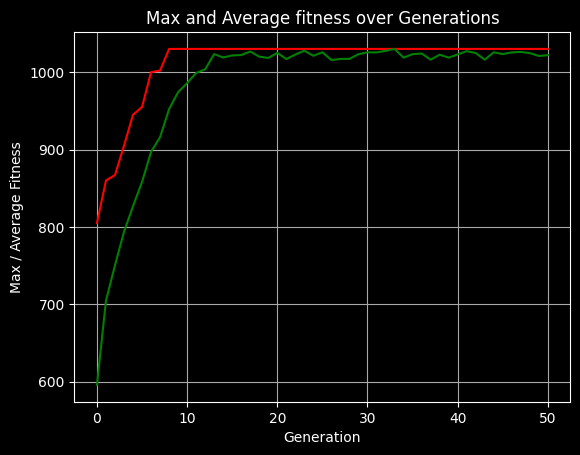

In [76]:
plt.style.use('dark_background')
plt.grid(color='darkgray')
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average fitness over Generations')
plt.show()